In [1]:
from tqdm import tqdm

from MULTIANGLE_QAOA.ma_qaoa_src.Ansatz import *
import scipy as sc
from qiskit.visualization import plot_histogram


In [2]:
# Generating random graph 
n = 4
rng_seed = int(np.random.randint(0,2**31-1))
np.random.seed(rng_seed)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edge_list = generate_random_graph(nodes=n,weighted=True,w_min=1e-2,seed=rng_seed)

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edge_list)


Best solution = [0 1 1 0] cost = -2.6109


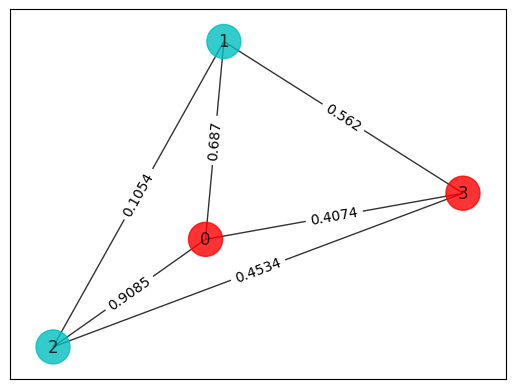

In [3]:
# Calculating optimal partition and plotting
best_cost, best_perm = qubo_min_cost_partition(nr_nodes=n,Q_mat=get_qubo(size=n,edges=edge_list))
colors = ["r" if best_perm[i] == 0 else "c" for i in range(n)]
print("\nBest solution = " + str(best_perm) + " cost = " + str(best_cost))
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)


In [4]:
# Number of repetitions of (cost, mixer) in circuit
layers=2

# Defining instance of QAOA ansatz
QAOA_objective = MAQAOAansatz(n_qubits=n, n_layers=layers, w_edges=edge_list, backend="SYMQ", precision=64)

# Initial guess for parameters (gamma, beta) of circuit
np.random.seed(0)
theta_min, theta_max = -np.pi, np.pi
gamma_i = np.random.uniform(low=theta_min, high=theta_max,size=QAOA_objective.nr_cost_terms * layers).tolist()
beta_i = np.random.uniform(low=theta_min, high=theta_max,size=QAOA_objective.nr_mixer_terms * layers).tolist()
theta_i = gamma_i + beta_i


# Function to track optimization progress using tqdm
def callback(xk,*_):
    pbar.update(1)

# ------ Optimizer run ------ #

# Optimizer technique 1)
_available_methods_ = ['Nelder-Mead', 'Powell', 'COBYLA', 'trust-constr']
with tqdm(total=None, desc="Optimizing", ascii=True) as pbar:
    res = sc.optimize.minimize(fun=QAOA_objective.evaluate_circuit, x0=theta_i,method=_available_methods_[2],callback=callback, options={'disp': True, 'maxiter': 5000})

# Optimizer technique 2)
#res = sc.optimize.basinhopping(func=QAOA_objective.evaluate_circuit, x0=theta_i, niter=10, stepsize=0.75)

# Optimizer technique 3)
#_available_strategies_ = ['best1bin', 'best1exp', 'rand1exp', 'randtobest1exp', 'currenttobest1exp', 'best2exp', 'rand2exp', 'randtobest1bin', 'currenttobest1bin', 'best2bin', 'rand2bin', 'rand1bin']
#res = sc.optimize.differential_evolution(func=QAOA_objective.evaluate_circuit,bounds=[(theta_min, theta_max) for angle in theta_i], strategy=_available_strategies_[1],popsize=2, maxiter=50)

# Optimizer technique 4)
#_available_sampling_methods_ = ['simplicial', 'halton', 'sobol']
#res = sc.optimize.shgo(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], sampling_method=_available_sampling_methods_[2],callback=printx)

# Optimizer technique 5)
#res = sc.optimize.dual_annealing(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=1000)

# Optimizer technique 6)
#res = sc.optimize.direct(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=400)

# Final parameters (beta, gamma) for circuit
theta_f = res.x.tolist()
res

Optimizing: 5001it [01:18, 63.59it/s]


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.6082454856528345
       x: [ 1.389e-02  4.162e+00 ... -2.441e+00  2.363e+00]
    nfev: 5000
   maxcv: 0.0

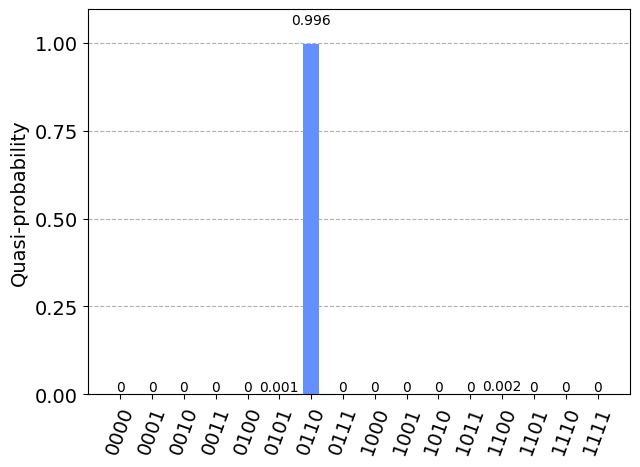

In [5]:
plot_histogram(QAOA_objective.set_circuit(theta=theta_f).get_state_probabilities(reverse_states=True))
